# Elo Merchant Category Recommendation - Stacking
End date: _2019. february 19._<br/>

This tutorial notebook is part of a series for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. LynxKite does not yet support some of the data preprocessing, thus they need to be done in Python. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

Inspired by [MultiModel + RIDGE + STACKING](https://www.kaggle.com/ashishpatel26/rmse-3-66-multimodel-ridge-stacking)<br/>
[KazaNova's presentation on stacking](https://www.coursera.org/lecture/competitive-data-science/stacking-Qdtt6)

In [1]:
import gc
import random
import warnings
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, KFold, train_test_split
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score

random.seed(1)
warnings.filterwarnings("ignore")

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Feature engineering

### Train & test data

In [3]:
df_train = pd.read_csv("input/train.csv", parse_dates=["first_active_month"])
df_train = reduce_mem_usage(df_train)
print("{:,} observations and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
201,917 observations and 6 features in train set.


In [4]:
df_test = pd.read_csv("input/test.csv", parse_dates=["first_active_month"])
df_test = reduce_mem_usage(df_test)
print("{:,} observations and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)
123,623 observations and 5 features in test set.


In [5]:
df_train['first_active_month'] = pd.to_datetime(df_train['first_active_month'])
df_train['elapsed_days'] = (datetime.date(2018, 2, 1) - df_train['first_active_month'].dt.date).dt.days

In [6]:
df_test['first_active_month'] = pd.to_datetime(df_test['first_active_month'])
df_test['elapsed_days'] = (datetime.date(2018, 2, 1) - df_test['first_active_month'].dt.date).dt.days

### Transactions

In [7]:
%%time
df_hist_trans = pd.read_csv('input/historical_transactions.csv', parse_dates=['purchase_date'])
df_hist_trans = reduce_mem_usage(df_hist_trans)
print('Number of historical transactions: {:,}'.format(len(df_hist_trans)))

Starting memory usage: 3109.54 MB
Reduced memory usage: 1749.11 MB (43.7% reduction)
Number of historical transactions: 29,112,361
CPU times: user 1min 13s, sys: 49.1 s, total: 2min 2s
Wall time: 2min 31s


In [8]:
%%time
df_new_trans = pd.read_csv('input/new_merchant_transactions.csv', parse_dates=['purchase_date'])
df_new_trans = reduce_mem_usage(df_new_trans)
print('Number of new transactions: {:,}'.format(len(df_new_trans)))

Starting memory usage: 209.67 MB
Reduced memory usage: 114.20 MB (45.5% reduction)
Number of new transactions: 1,963,031
CPU times: user 5.27 s, sys: 500 ms, total: 5.77 s
Wall time: 6.4 s


In [9]:
df_new_trans.isna().sum()

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

Missing data handling (why these values?)

In [10]:
for df in [df_hist_trans, df_new_trans]:
    df['category_2'].fillna(1.0, inplace=True)
    df['category_3'].fillna('A', inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)

Date handling

In [11]:
def create_date_features(df, source_column, preposition):
    df[preposition + '_year'] = df[source_column].dt.year
    df[preposition + '_month'] = df[source_column].dt.month
    df[preposition + '_day'] = df[source_column].dt.day
    df[preposition + '_hour'] = df[source_column].dt.hour
    df[preposition + '_weekofyear'] = df[source_column].dt.weekofyear
    df[preposition + '_dayofweek'] = df[source_column].dt.dayofweek
    df[preposition + '_weekend'] = (df[source_column].dt.weekday >=5).astype(int)
    df[preposition + '_quarter'] = df[source_column].dt.quarter
    
    return df

In [12]:
df_hist_trans['authorized_flag'] = df_hist_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_hist_trans['category_1'] = df_hist_trans['category_1'].map({'N': 0, 'Y': 1})

df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])
df_hist_trans = create_date_features(df_hist_trans, 'purchase_date', 'purchase')

In [13]:
df_new_trans['authorized_flag'] = df_new_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_new_trans['category_1'] = df_new_trans['category_1'].map({'N': 0, 'Y': 1})

df_new_trans['purchase_date'] = pd.to_datetime(df_new_trans['purchase_date'])
df_new_trans = create_date_features(df_new_trans, 'purchase_date', 'purchase')

In [14]:
df_hist_trans['month_diff'] = ((datetime.date(2018, 12, 1) - df_hist_trans['purchase_date'].dt.date).dt.days)//30
df_hist_trans['month_diff'] += df_hist_trans['month_lag']

In [15]:
df_new_trans['month_diff'] = ((datetime.date(2018, 12, 1) - df_new_trans['purchase_date'].dt.date).dt.days)//30
df_new_trans['month_diff'] += df_new_trans['month_lag']

In [16]:
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 3748.10 MB
Reduced memory usage: 1638.06 MB (56.3% reduction)


In [17]:
df_new_trans = reduce_mem_usage(df_new_trans)

Starting memory usage: 248.99 MB
Reduced memory usage: 106.71 MB (57.1% reduction)


#### Aggregation

In [18]:
def aggregate_transactions(df, prefix):
    agg_funcs = {
        'authorized_flag': ['sum', 'mean'],

        'card_id': ['size'],
        'category_1': ['sum', 'mean'],
        
        'installments': ['sum', 'max', 'min', 'mean', 'var'],

        'merchant_category_id': ['nunique'],
        'merchant_id': ['nunique'],
        'month_diff': ['mean'],
        'month_lag': ['max','min','mean','var'],

        'purchase_amount': ['sum', 'max', 'min', 'mean', 'var'],
        'purchase_date': ['max', 'min'],
        'purchase_dayofweek': ['nunique'],
        'purchase_hour': ['nunique'],
        'purchase_month': ['nunique'],
        'purchase_year': ['nunique'],
        'purchase_weekend': ['sum', 'mean'],
        'purchase_weekofyear': ['nunique'],

        'subsector_id': ['nunique']
    }

    df['category_2_mean'] = df.groupby(['category_2'])['purchase_amount'].transform('mean')
    df['category_3_mean'] = df.groupby(['category_3'])['purchase_amount'].transform('mean')

    df_agg = df.groupby('card_id').agg(agg_funcs)
    df_agg.columns = [prefix + '_' + '_'.join(col).strip() for col in df_agg.columns.values]
    df_agg.reset_index(drop=False, inplace=True)
    df_agg[prefix + '_purchase_date_diff'] = (df_agg[prefix + '_purchase_date_max'] - df_agg[prefix + '_purchase_date_min']).dt.days
    df_agg[prefix + '_purchase_date_average'] = df_agg[prefix + '_purchase_date_diff']/df_agg[prefix + '_card_id_size']
    df_agg[prefix + '_purchase_date_uptonow'] = (datetime.datetime.today() - df_agg[prefix + '_purchase_date_max']).dt.days

    df = (df_agg.groupby('card_id').size().reset_index(name='{}_transactions_count'.format(prefix)))
    df_agg = pd.merge(df, df_agg, on='card_id', how='left')
    return df_agg

In [19]:
df_hist_agg = aggregate_transactions(df_hist_trans, 'hist')
df_new_agg = aggregate_transactions(df_new_trans, 'new')

df_train = df_train.merge(df_hist_agg, on='card_id', how='left')
df_train = df_train.merge(df_new_agg, on='card_id', how='left')

df_test = df_test.merge(df_hist_agg, on='card_id', how='left')
df_test = df_test.merge(df_new_agg, on='card_id', how='left')

In [20]:
df_hist_agg[:3]

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_card_id_size,hist_category_1_sum,hist_category_1_mean,hist_installments_sum,hist_installments_max,hist_installments_min,...,hist_purchase_hour_nunique,hist_purchase_month_nunique,hist_purchase_year_nunique,hist_purchase_weekend_sum,hist_purchase_weekend_mean,hist_purchase_weekofyear_nunique,hist_subsector_id_nunique,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow
0,C_ID_00007093c1,1,114.0,0.765101,149,28.0,0.187919,192,6,1,...,18,12,2,25.0,0.167785,39,13,377,2.530201,363
1,C_ID_0001238066,1,120.0,0.975610,123,2.0,0.016260,198,10,-1,...,20,6,2,52.0,0.422764,23,17,151,1.227642,362
2,C_ID_0001506ef0,1,62.0,0.939394,66,0.0,0.000000,1,1,0,...,15,11,2,32.0,0.484848,24,12,398,6.030303,373


In [21]:
del df_hist_trans, df_new_trans, df_hist_agg, df_new_agg
gc.collect()

84

In [22]:
df_train['hist_first_buy'] = (df_train['hist_purchase_date_min'] - df_train['first_active_month']).dt.days
df_train['new_first_buy'] = (df_train['new_purchase_date_min'] - df_train['first_active_month']).dt.days

df_test['hist_first_buy'] = (df_test['hist_purchase_date_min'] - df_test['first_active_month']).dt.days
df_test['new_first_buy'] = (df_test['new_purchase_date_min'] - df_test['first_active_month']).dt.days

In [23]:
for f in ['hist_purchase_date_max', 'hist_purchase_date_min', 'new_purchase_date_max', 'new_purchase_date_min']:
    df_train[f] = df_train[f].astype(np.int64) * 1e-9
    df_test[f] = df_test[f].astype(np.int64) * 1e-9

df_train['card_id_total'] = df_train['hist_card_id_size'] + df_train['new_card_id_size']
df_test['card_id_total'] = df_test['hist_card_id_size'] + df_test['new_card_id_size']

df_train['purchase_amount_total'] = df_train['hist_purchase_amount_sum'] + df_train['new_purchase_amount_sum']
df_test['purchase_amount_total'] = df_test['hist_purchase_amount_sum'] + df_test['new_purchase_amount_sum']

In [24]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [25]:
for f in ['feature_1', 'feature_2', 'feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [26]:
df_train.to_csv('preprocessed/train_merged.csv')
df_test.to_csv('preprocessed/test_merged.csv')

### Loading possible outliers

In [27]:
df_train_po = pd.read_csv("preprocessed/possible_outliers_train_gt0.9.csv")
df_train_po = reduce_mem_usage(df_train_po)
print("{:,} observations and {} features in train set.".format(df_train_po.shape[0], df_train_po.shape[1]))

Starting memory usage:  3.08 MB
Reduced memory usage:  1.73 MB (43.7% reduction)
201,917 observations and 2 features in train set.


In [28]:
df_test_po = pd.read_csv("preprocessed/possible_outliers_test_gt0.9.csv")
df_test_po = reduce_mem_usage(df_test_po)
print("{:,} observations and {} features in train set.".format(df_test_po.shape[0], df_test_po.shape[1]))

Starting memory usage:  1.89 MB
Reduced memory usage:  1.06 MB (43.7% reduction)
123,623 observations and 2 features in train set.


In [29]:
len(df_train_po[df_train_po['possible_out'] == 1]), len(df_test_po[df_test_po['possible_out'] == 1])

(31039, 335)

In [30]:
df_train = df_train.merge(df_train_po, on='card_id', how='left')
df_test = df_test.merge(df_test_po, on='card_id', how='left')

### Training
[LightGBM parameter tuning](https://testlightgbm.readthedocs.io/en/latest/Parameters-tuning.html)<br/>
[What is LightGBM, How to implement it? How to fine tune the parameters?](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc)

In [31]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month', 'target', 'outliers']]
target = df_train['target']
del df_train['target']

In [32]:
train_set, valid_set, y_train, y_valid = train_test_split(df_train, target, test_size=0.5)

#### LightGBM

In [33]:
%%time
param = {
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "boosting": "gbdt",

    "feature_fraction": 0.9,
    #"feature_fraction_seed": 1,

    "lambda_l1": 0.1,
    "learning_rate": 0.01,

    #"max_bin": 5,
    'max_depth': -1,
    "metric": "rmse",
    #"min_data_in_leaf": 30,
    #"min_gain_to_split": 0.1,
    "min_child_samples": 20,
    #"num_boost_round": 100,
    "num_leaves": 31,
    "nthread": -1,

    "objective": "regression",

    "random_state": 402,
    "verbosity": -1
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=402)
oof_lgbm = np.zeros(len(df_train))
predictions_lgbm = np.zeros(len(df_test))
feature_importance_lgbm = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, df_train['possible_out'].values)):
    print("\nFold {}.".format(fold_+1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    num_round = 10000
    model_lgbm = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof_lgbm[val_idx] = model_lgbm.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=model_lgbm.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df_train_columns
    fold_importance_df["importance"] = model_lgbm.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_lgbm = pd.concat([feature_importance_lgbm, fold_importance_df], axis=0)
    
    predictions_lgbm += model_lgbm.predict(df_test[df_train_columns], num_iteration=model_lgbm.best_iteration) / folds.n_splits


Fold 1.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.6511	valid_1's rmse: 3.77401
[200]	training's rmse: 3.57181	valid_1's rmse: 3.74251
[300]	training's rmse: 3.52178	valid_1's rmse: 3.73064
[400]	training's rmse: 3.48234	valid_1's rmse: 3.72359
[500]	training's rmse: 3.44985	valid_1's rmse: 3.71852
[600]	training's rmse: 3.42256	valid_1's rmse: 3.71448
[700]	training's rmse: 3.39812	valid_1's rmse: 3.71155
[800]	training's rmse: 3.37731	valid_1's rmse: 3.70977
[900]	training's rmse: 3.35635	valid_1's rmse: 3.70767
[1000]	training's rmse: 3.33782	valid_1's rmse: 3.70622
[1100]	training's rmse: 3.32077	valid_1's rmse: 3.70584
[1200]	training's rmse: 3.30378	valid_1's rmse: 3.70441
[1300]	training's rmse: 3.28667	valid_1's rmse: 3.70378
[1400]	training's rmse: 3.2706	valid_1's rmse: 3.70317
[1500]	training's rmse: 3.2553	valid_1's rmse: 3.7026
[1600]	training's rmse: 3.24003	valid_1's rmse: 3.70212
[1700]	training's rmse: 3.22477	valid_1's rms

In [34]:
cv_score_lgbm = np.sqrt(mean_squared_error(oof_lgbm, target))
print("CV score: {:.6f}".format(cv_score_lgbm))

CV score: 3.655328


In [35]:
model_lgbm.save_model("models/lightgbm_{:.6f}.txt".format(cv_score_lgbm))

In [ ]:
model_lgbm = lgb.Booster(model_file='models/lightgbm_3.655203.txt')

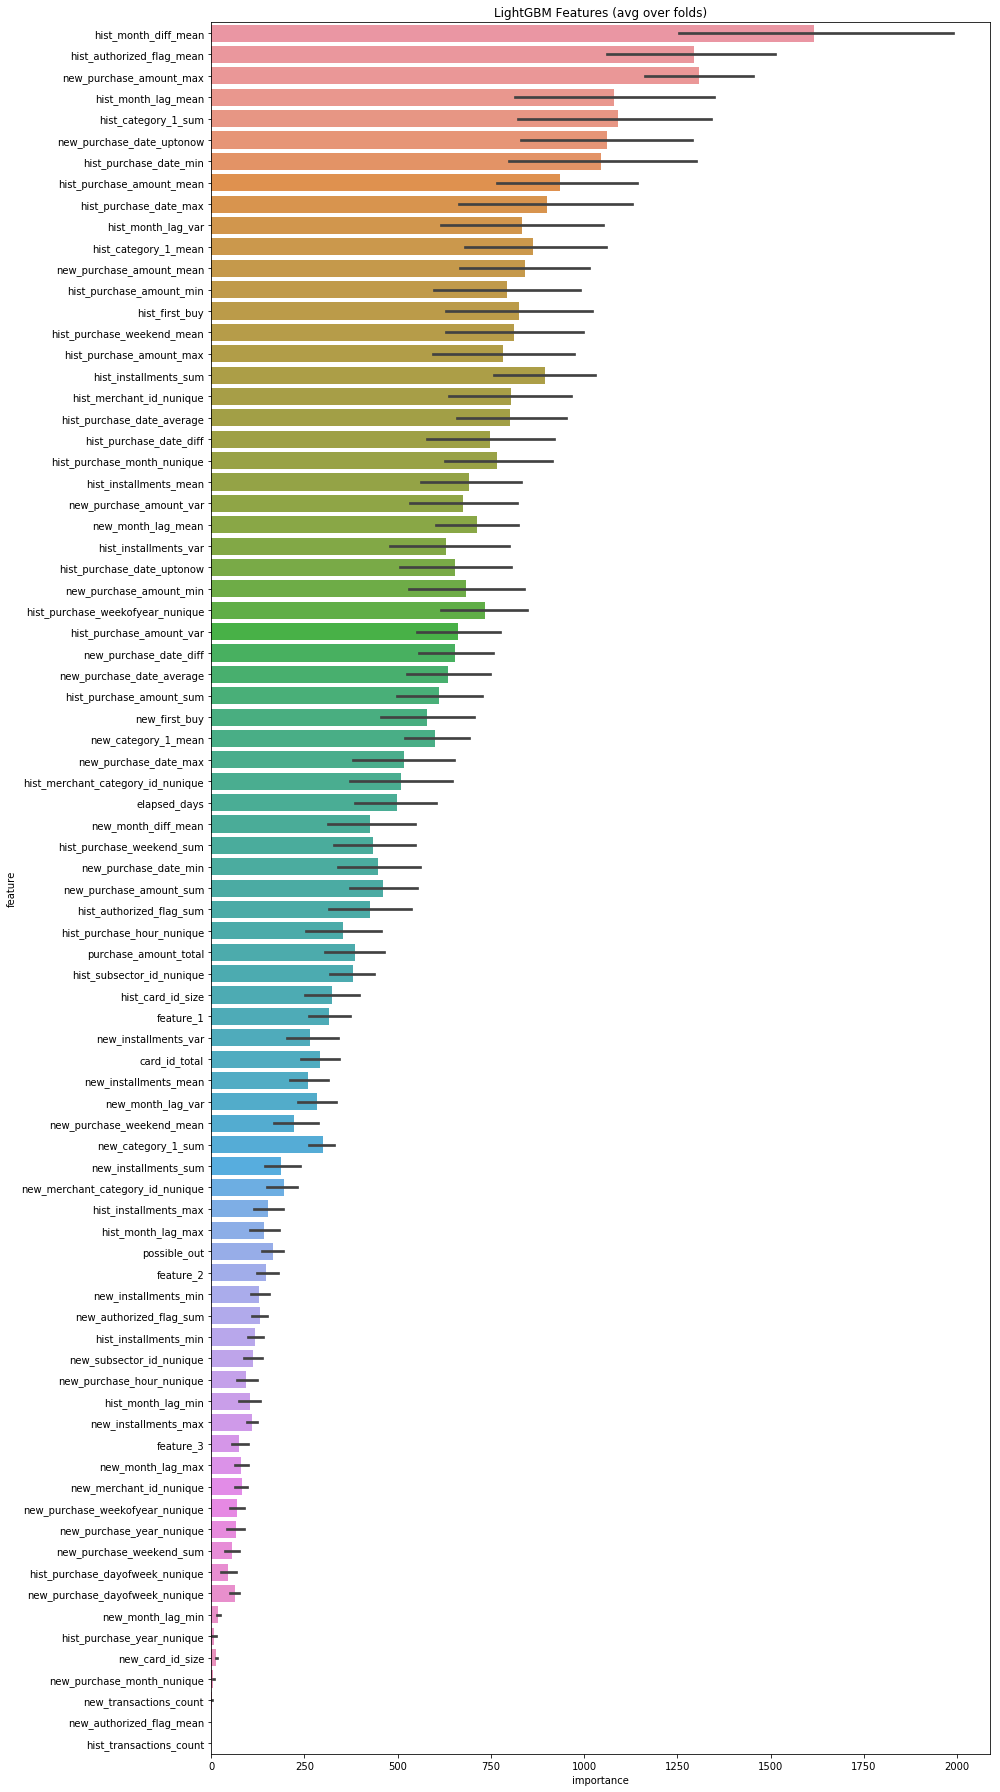

In [36]:
cols = (feature_importance_lgbm[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features_lgbm = feature_importance_lgbm.loc[feature_importance_lgbm.feature.isin(cols)]

plt.figure(figsize=(14, 25))
sns.barplot(x="importance", y="feature", data=best_features_lgbm.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

#### XGBoost

In [42]:
%%time
params = {
    'colsample_bytree': 0.8,
    'eta': 0.005,
    'eval_metric': 'rmse',
    'max_depth': 3,
    'objective': 'reg:linear',
    'random_state': 1,
    'silent': True,
    'subsample': 0.8
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=402)
oof_xgb = np.zeros(len(df_train))
predictions_xgb = np.zeros(len(df_test))
feature_importance_xgb = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, df_train['possible_out'].values)):
    print("\nFold {}.".format(fold_+1))
    trn_data = xgb.DMatrix(data=df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]

    num_round = 10000
    model_xgb = xgb.train(params, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)
    oof_xgb[val_idx] = model_xgb.predict(xgb.DMatrix(df_train.iloc[val_idx][df_train_columns]), ntree_limit=model_xgb.best_ntree_limit+50)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df_train_columns
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_lxgb = pd.concat([feature_importance_xgb, fold_importance_df], axis=0)
    
    predictions_xgb += model_xgb.predict(xgb.DMatrix(df_test[df_train_columns]), ntree_limit=model_xgb.best_ntree_limit+50) / folds.n_splits


Fold 1.
[15:55:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1250 extra nodes, 0 pruned nodes, max_depth=10
[0]	train-rmse:3.85013	valid-rmse:3.96109
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[15:55:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1378 extra nodes, 0 pruned nodes, max_depth=10
[15:55:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1248 extra nodes, 0 pruned nodes, max_depth=10
[15:55:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1274 extra nodes, 0 pruned nodes, max_depth=10
[15:55:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1238 extra nodes, 0 pruned nodes, max_depth=10
[15:55:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1212 extra nodes, 0 pruned nodes, max_depth=10
[15:55:52] /workspace/src/tree/updater_prune.cc:

[15:56:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1200 extra nodes, 0 pruned nodes, max_depth=10
[15:56:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 562 extra nodes, 0 pruned nodes, max_depth=10
[15:56:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 794 extra nodes, 0 pruned nodes, max_depth=10
[15:56:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 886 extra nodes, 0 pruned nodes, max_depth=10
[15:56:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 714 extra nodes, 0 pruned nodes, max_depth=10
[15:56:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 854 extra nodes, 0 pruned nodes, max_depth=10
[15:56:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1030 extra nodes, 0 pruned nodes, max_depth=10
[15:56:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=1

[15:57:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 642 extra nodes, 0 pruned nodes, max_depth=10
[15:57:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 864 extra nodes, 0 pruned nodes, max_depth=10
[15:57:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 788 extra nodes, 0 pruned nodes, max_depth=10
[15:57:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 624 extra nodes, 0 pruned nodes, max_depth=10
[15:57:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 898 extra nodes, 0 pruned nodes, max_depth=10
[15:57:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 694 extra nodes, 0 pruned nodes, max_depth=10
[15:57:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 838 extra nodes, 0 pruned nodes, max_depth=10
[15:57:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 638 extra nodes, 0 pruned nodes, max_depth=10


[15:58:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[15:58:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 906 extra nodes, 0 pruned nodes, max_depth=10
[15:58:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 998 extra nodes, 0 pruned nodes, max_depth=10
[15:58:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=10
[15:58:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 714 extra nodes, 0 pruned nodes, max_depth=10
[15:58:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 752 extra nodes, 0 pruned nodes, max_depth=10
[15:58:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=10
[15:58:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 696 extra nodes, 0 pruned nodes, max_depth=10


[15:59:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 618 extra nodes, 0 pruned nodes, max_depth=10
[15:59:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 946 extra nodes, 0 pruned nodes, max_depth=10
[15:59:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 864 extra nodes, 0 pruned nodes, max_depth=10
[15:59:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 514 extra nodes, 0 pruned nodes, max_depth=10
[15:59:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1010 extra nodes, 0 pruned nodes, max_depth=10
[15:59:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 722 extra nodes, 0 pruned nodes, max_depth=10
[15:59:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 774 extra nodes, 0 pruned nodes, max_depth=10
[15:59:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 812 extra nodes, 0 pruned nodes, max_depth=10

[16:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1058 extra nodes, 0 pruned nodes, max_depth=10
[16:00:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 982 extra nodes, 0 pruned nodes, max_depth=10
[16:00:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1020 extra nodes, 0 pruned nodes, max_depth=10
[16:00:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1000 extra nodes, 0 pruned nodes, max_depth=10
[16:00:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 962 extra nodes, 0 pruned nodes, max_depth=10
[16:00:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 744 extra nodes, 0 pruned nodes, max_depth=10
[16:00:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1072 extra nodes, 0 pruned nodes, max_depth=10
[16:00:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 970 extra nodes, 0 pruned nodes, max_depth

In [43]:
cv_score_xgb = np.sqrt(mean_squared_error(oof_xgb, target))
print("CV score: {:.6f}".format(cv_score_xgb))

CV score: 3.706166


In [39]:
joblib.dump(model_xgb, "models/xgboost_{:.6f}.pkl".format(cv_score_xgb), compress=True)

['models/xgboost_3.681975.pkl']

In [ ]:
model_xgb = joblib.load('models/xgboost_3.657233.pkl')

In [ ]:
sub_df = pd.DataFrame({
    "card_id": df_test["card_id"].values
})

sub_df["target"] = predictions
sub_df.to_csv("output/xgboost_{:.6f}.csv".format(cv_score), index=False)

#### Meta model

In [44]:
train_stack = np.vstack([oof_lgbm, oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgbm, predictions_xgb]).transpose()

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, target)):
    print("\nFold {}.".format(fold_+1))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    model_ridge = Ridge(alpha=100)
    model_ridge.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = model_ridge.predict(val_data)
    predictions_stack += model_ridge.predict(test_stack) / 5


Fold 1.

Fold 2.

Fold 3.

Fold 4.

Fold 5.


In [45]:
cv_score_stack = np.sqrt(mean_squared_error(oof_stack, target))
print("CV score: {:.6f}".format(cv_score_stack))

CV score: 3.654925


In [ ]:
sub_df = pd.DataFrame({
    "card_id": df_test["card_id"].values
})

sub_df["target"] = predictions_stack
sub_df.to_csv("output/stacked_{:.6f}.csv".format(cv_score_stack), index=False)

### Weighted averaging the predicted outliers

In [49]:
sub_df = pd.DataFrame({
    "card_id": df_test["card_id"].values
})

sub_df["target"] = predictions_stack

In [47]:
df_test_po[df_test_po['possible_out'] == 1].count()

card_id         335
possible_out    335
dtype: int64

In [50]:
sub_df = sub_df.merge(df_test_po, on='card_id', how='left')

In [52]:
sub_df[sub_df['possible_out'] == 1][:5]

,card_id,target,possible_out
162,C_ID_10a8a42d77,-10.704906,1
223,C_ID_eb0cba1af9,-2.334260,1
559,C_ID_c8c081b4b4,-0.843567,1
813,C_ID_e140330b78,-0.652716,1
1023,C_ID_bb5ad40d85,-0.613896,1


In [53]:
sub_df['target'] = sub_df.apply(lambda row: row['target'] if row['possible_out'] == 0 else (0.9 * row['target'] - 33.219281 * 0.1), axis = 1) 

In [54]:
sub_df[sub_df['possible_out'] == 1][:5]

,card_id,target,possible_out
162,C_ID_10a8a42d77,-15.207781,1
223,C_ID_eb0cba1af9,-8.511264,1
559,C_ID_c8c081b4b4,-7.318710,1
813,C_ID_e140330b78,-7.166029,1
1023,C_ID_bb5ad40d85,-7.134973,1


In [57]:
sub_df.drop('possible_out', axis=1, inplace=True)

In [59]:
sub_df.to_csv("output/stacked_wavg_{:.6f}.csv".format(cv_score_stack), index=False)
print("output/stacked_wavg_{:.6f}.csv".format(cv_score_stack))

output/stacked_wavg_3.654925.csv


[Just Train Data - LGB & XGB & CatBoost w/ Blending](https://www.kaggle.com/silverstone1903/just-train-data-lgb-xgb-catboost-w-blending/data)<br/>
[MultiModel + RIDGE + STACKING](https://www.kaggle.com/ashishpatel26/rmse-3-66-multimodel-ridge-stacking)
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/75935